## Импортируем необходимые бибилиотеки

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import missingno as msno

import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

%matplotlib inline

RANDOM_SEED = 42 # сразу выставим значение random_seed

## Загрузим данные для работы

In [161]:
df_train = pd.read_csv('main_task_new.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')
# Загружаем данные о городах для дальнейшего использования

cities = pd.read_csv('cities.csv', sep=';')
cities.set_index('city', inplace=True)

In [162]:
# Взглянем на датасеты поверхностно
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


None

In [163]:
# Посмотрим на примеры из датасетов
display(df_train.head(1))
display(df_test.head(1))

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918


In [164]:
# Посмотрим на sample_submission
display(sample_submission.info())
display(sample_submission.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


None

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [165]:
# Обединяем тренировочный и тестовые датасеты

df_train['sample'] = 1 # добавляем столбец и помечаем третировочные данные
df_test['sample'] = 0 # добавляем столбец и помечаем тестовые данные
df_test['Rating'] = 0 # добавляем в тестовые данные столбец с целевой переменной и заполняем его '0'

data = df_test.append(df_train).reset_index(drop=True)

In [166]:
# Посмотрим на результирующий датасет
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


#### Что из себя представляют признаки:
* Restaurant_id: ID ресторана
* City: Город расположения ресторана
* Cuisine Style: Представленная кухня
* Ranking: Ранг ресторана в указанном городе
* Price Range: ценовой диапазон из 3-х категорий
* Number of Reviews: количество отзывов
* Reviews: два последних отзыва с датами
* URL_TA: URL странички ресторана на сайте
* ID_TA: идентификатор ресторана в базе tripadvisor.com
* Rating: рейтинг ресторана (целевая переменная)

## Разведывательный анализ данных (EDA)

In [167]:
# Смотрим на пропцщенные значения
df_train.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style         9283
Ranking                  0
Rating                   0
Price Range          13886
Number of Reviews     2543
Reviews                  0
URL_TA                   0
ID_TA                    0
sample                   0
dtype: int64

<AxesSubplot:>

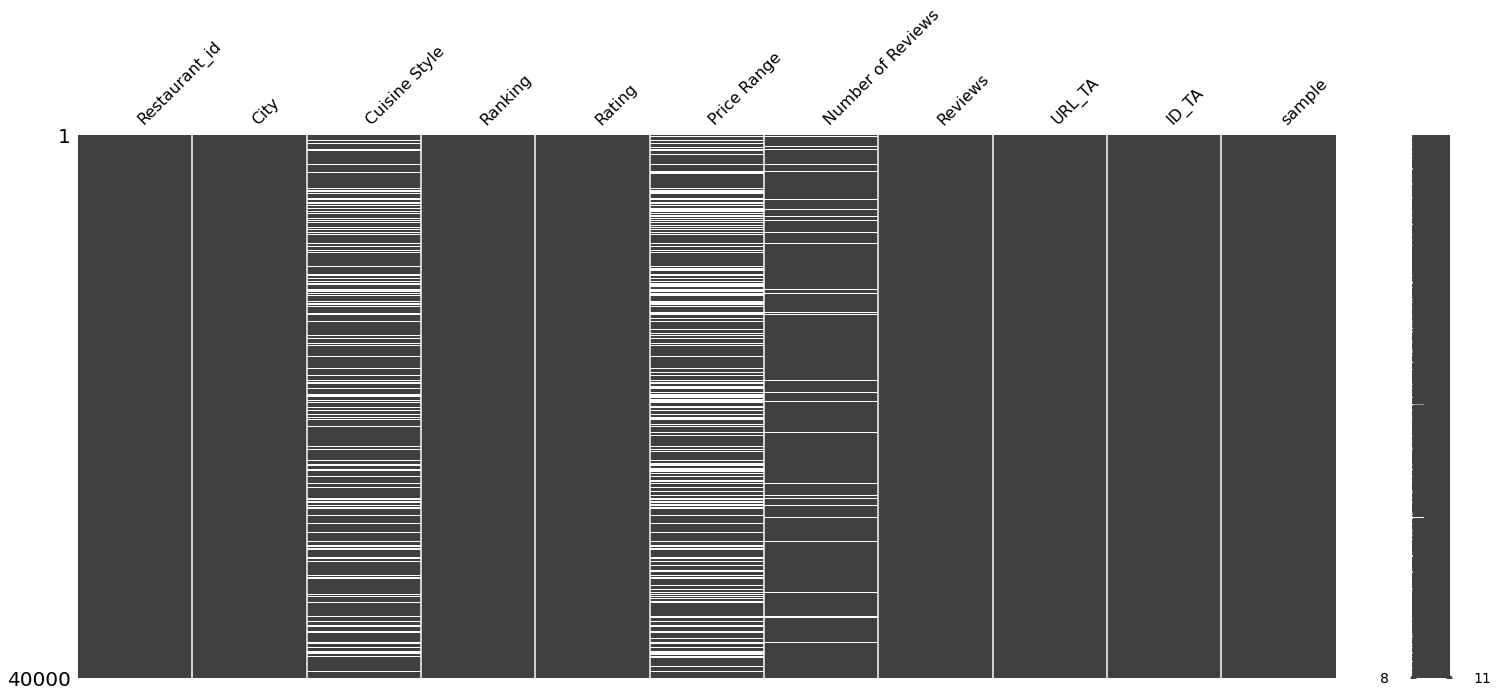

In [168]:
# Нарисуем пропущенные значения
msno.matrix(df_train)

<AxesSubplot:>

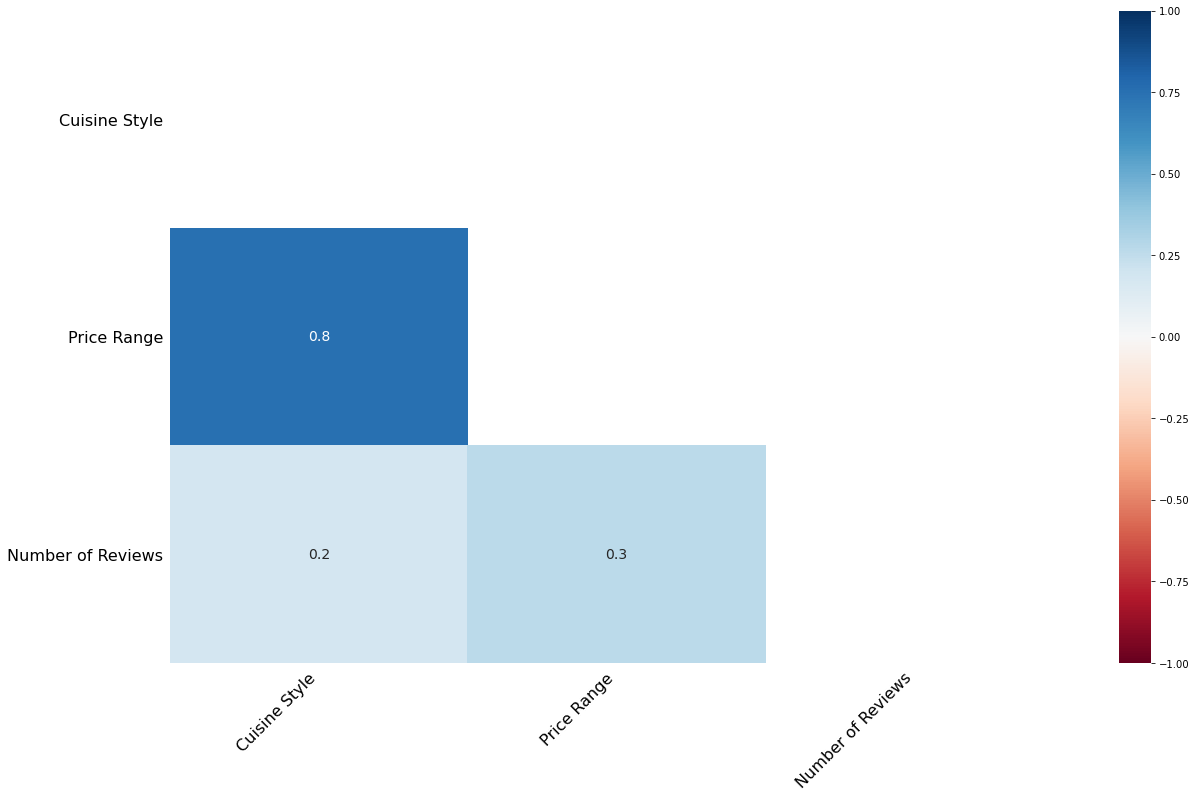

In [169]:
msno.heatmap(df_train)

В визуализации видна свзяь между пропущенными значениями в Cuisine Style и Price Range 

In [170]:
# Смотрим на совпадения пропущенных данных
display(df_train['Restaurant_id'][df_train['Cuisine Style'].isna() & df_train['Price Range'].isna()].value_counts().sum())


9283

Делаем вывод, что все пропущенные значения в Cuisine Style также отсутствуют в Price Range

<AxesSubplot:>

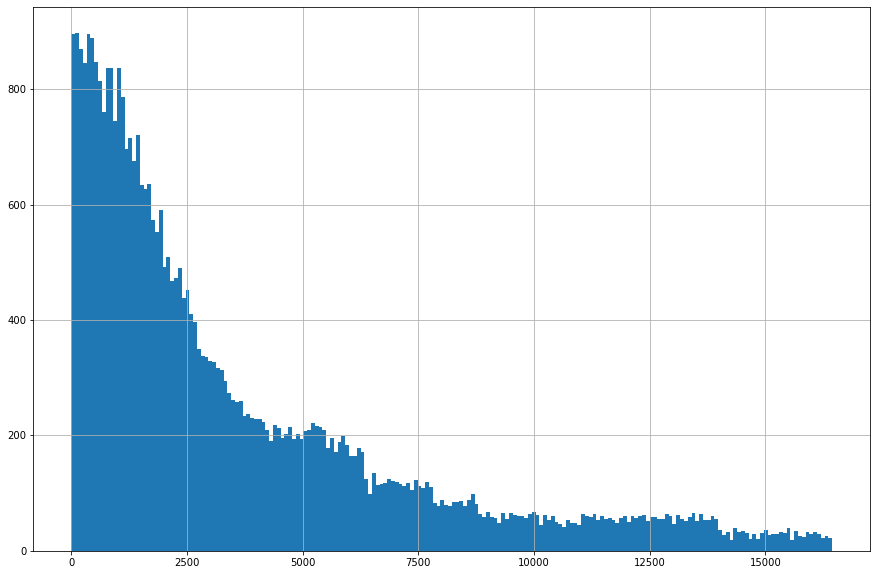

In [171]:
# Смотрим на распределние ранга ресторанов
df_train['Ranking'].hist(bins=200, figsize=(15, 10))

<AxesSubplot:>

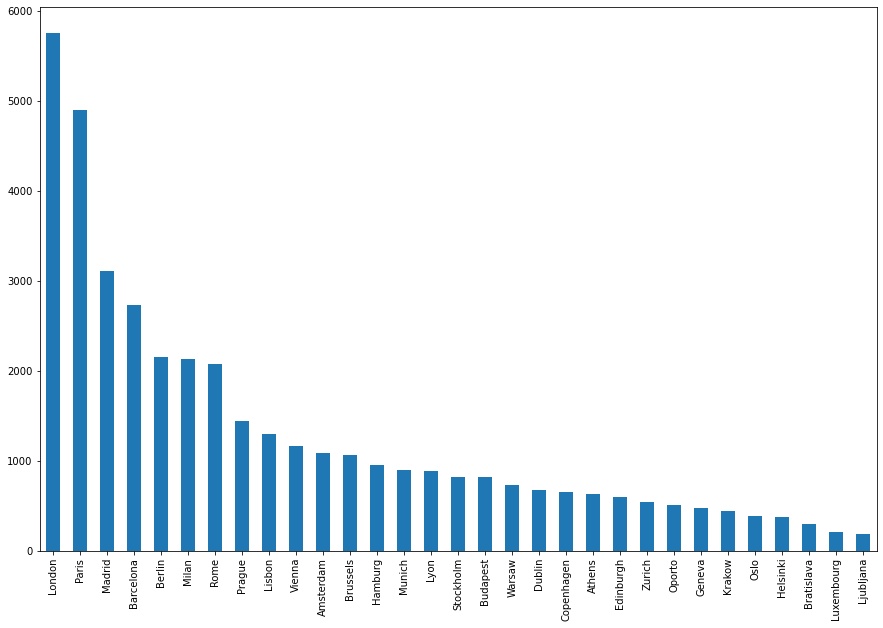

In [172]:
# Теперь в разрезе городов
df_train['City'].value_counts().plot(kind='bar', figsize=(15, 10))

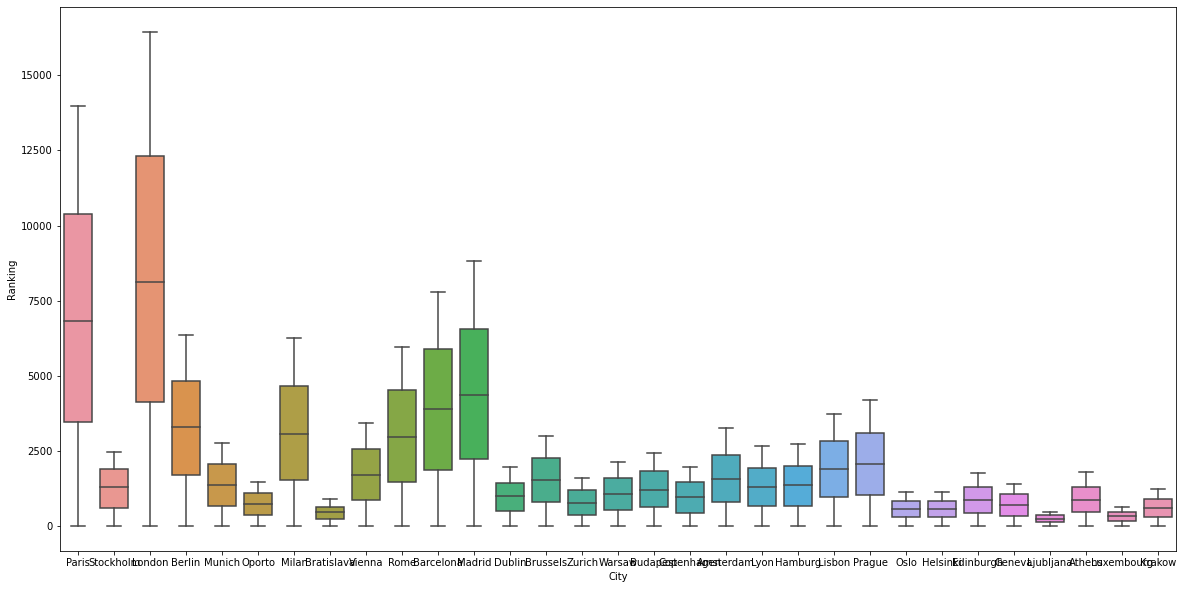

In [173]:
# Посмотрим распределение по кадому городу
dims = (20, 10)

fig, ax = plt.subplots(figsize=dims)

ax = sns.boxplot(ax=ax, x=df_train['City'], y=df_train['Ranking'])

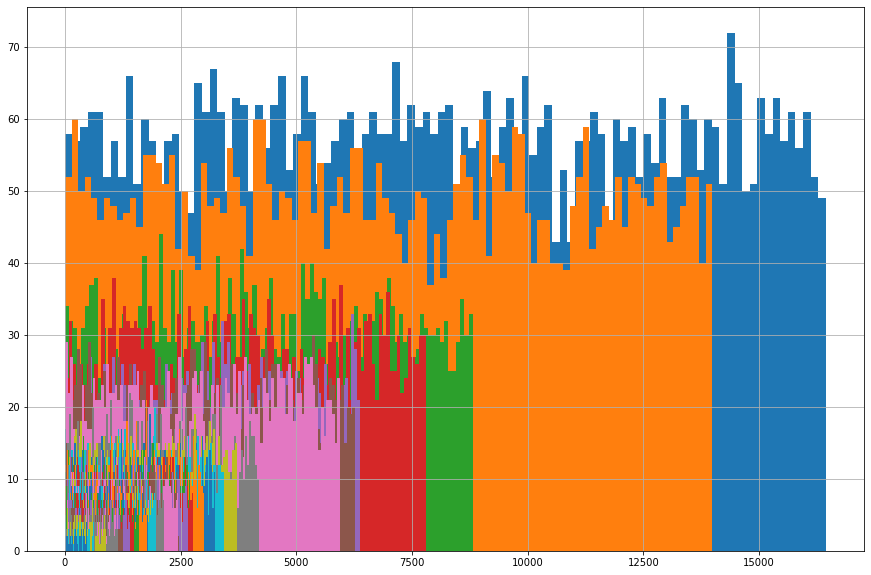

In [174]:
# Посмотрим распределение по кадому городу в другом виде
for item in df_train['City'].value_counts().index:
    df_train['Ranking'][df_train['City'] == item].hist(bins=100, figsize=(15, 10))

<AxesSubplot:>

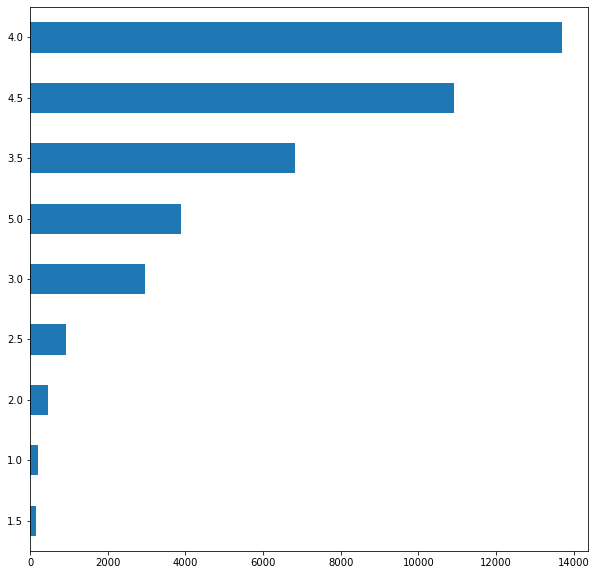

In [175]:
# Взглянем на распределние целевой переменной
plt.rcParams["figure.figsize"] = [10, 10]

df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

<AxesSubplot:>

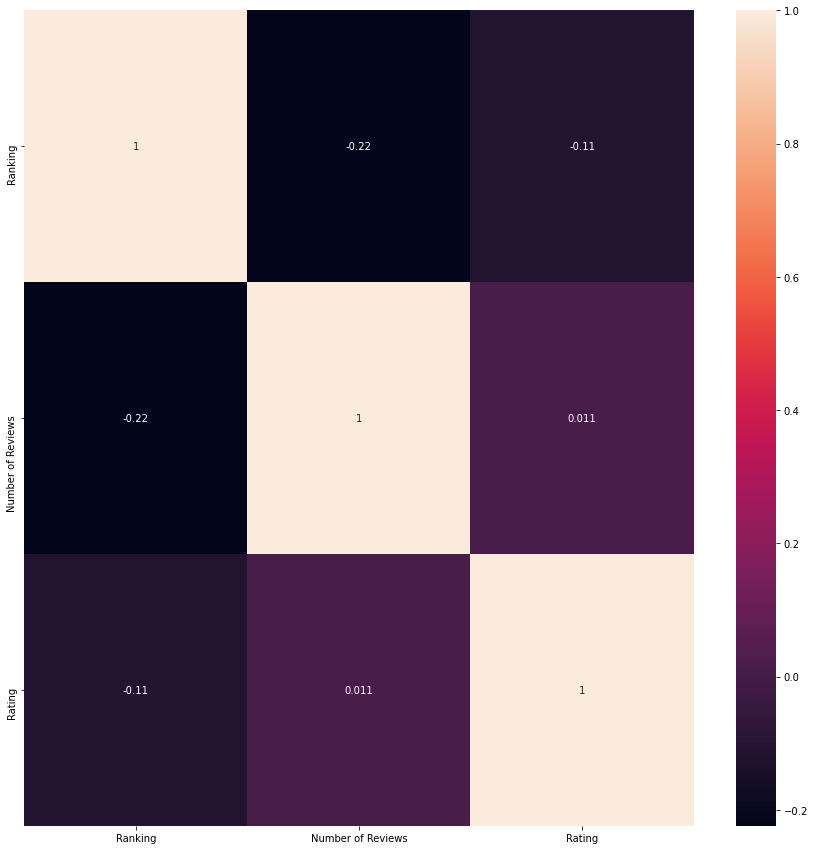

In [176]:
# Взглянем на корреляцию числовых данных
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

## Очистка, подготовка и обогащение данных

In [177]:
# Снова посмотрим на датасет
display(data.info())
display(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


None

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

In [178]:
# Переименум столбцы для удобства
data.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking', 'price_range', 
                'number_of_reviews', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating']

# Исправим название города
data.city[data.city == 'Oporto'] = 'Porto'

In [179]:
# Смотрим на price_range
data.price_range.value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

In [180]:
# Заполним пропуски в Price Range наиболее частым значением, также видно,
# что ценовые диапазоны можно представить порядковыми признаками
# 
# $ как 1
# $$ - $$$ как 2
# $$$$ как 3

data.price_range = data.price_range.astype(str).apply(lambda x: 1 if x == '$' else 2 if x == '$$ - $$$' else 3 if x == '$$$$'
                                          else 2 if x == 'nan' else x)


In [181]:
# Заполним пропущенные значения в кухнях на 'Other'

data.cuisine_style[data.cuisine_style.isna()] = 'Other'

In [182]:
# Пропущенные значения в Number Of Reviews заполним средними значениями для города


review_mean = data.groupby('city')['number_of_reviews'].mean()

data.number_of_reviews.fillna(value=0, inplace=True)

data['number_of_reviews'] = data.apply(lambda row: review_mean[row['city']] if row['number_of_reviews'] == 0
                                                           else row['number_of_reviews'], axis=1)
display(data.isna().sum())

restaurant_id        0
city                 0
cuisine_style        0
ranking              0
price_range          0
number_of_reviews    0
reviews              2
url_ta               0
id_ta                0
sample               0
rating               0
dtype: int64

In [183]:
# Посмотрим на результат
data.sample()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating
46535,id_9092,London,['Seafood'],9101.0,2,2.0,"[['Excellent takeaway', 'Best fish and chips!'...",/Restaurant_Review-g186338-d7275902-Reviews-Gr...,d7275902,1,5.0


In [184]:
#
# Поработаем с городами, добавим несколько новых признаков, а также посмотрим на ID_TA
#
# Добавим данные о населении
data['population'] = data.city.apply(lambda x: cities.loc[x].population)

# Добавим бинарный признак столица - не столица
data['is_capital'] = data.city.apply(lambda x: cities.loc[x].is_capital)

# Посчитаем количество ресторанов в городе
rest_count = pd.DataFrame(data.groupby('city')['ranking'].count())

# Добавим признак количества ресторанов в датафрейм
data['rest_in_city'] = data.city.apply(lambda x: rest_count.loc[x].ranking)

# Добавим соотношение населения к количеству ресторанов
data['pop_by_rest'] = data['population'] / data['rest_in_city']

# Добавим соотношение населения к количеству отзывов
data['pop_by_review'] = data['number_of_reviews'] / data['population']

# Добавим ранк ресторана в соотношении к количеству ресторанов в городе
data['rank_by_city'] = data['ranking'] / data['rest_in_city']

# Обработаем ID_TA

data['id_ta'] = data['id_ta'].apply(lambda x: x[1:]) # убираем префикс 'd'
data['id_ta'] = data['id_ta'].apply(lambda x: int(x)) # приводим значения в тип int

In [185]:
data.sample()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,population,is_capital,rest_in_city,pop_by_rest,pop_by_review,rank_by_city
11999,id_879,Milan,"['Italian', 'Mediterranean', 'European', 'Deli...",881.0,3,333.0,"[['quite good but a bit overpriced', 'Truffle ...",/Restaurant_Review-g187849-d7303001-Reviews-Ta...,7303001,1,4.0,1366180,0,2694,507.119525,0.000244,0.327023


In [186]:
# Работаем с набором кухонь

data['cuisine_style'] = data['cuisine_style'].astype(str).apply(lambda x: x.replace("[", ""))
data['cuisine_style'] = data['cuisine_style'].astype(str).apply(lambda x: x.replace("]", ""))
data['cuisine_style'] = data['cuisine_style'].astype(str).apply(lambda x: x.replace("'", ""))
data['cuisine_style'] = data['cuisine_style'].astype(str).apply(lambda x: x.split(', '))

# Добавим вспомогательный датасет
support_df = data.explode('cuisine_style')


In [187]:
# Создаем списки из уникальных кухонь и городов
cui_style_set = set(support_df.cuisine_style)

city_set = set(support_df.city)

In [188]:
# Объявим функцию, которая будет проставлять 0 или 1 в зависимости от присутствия кухни в списке
def find_item(cell):
    if item in cell:
        return 1
    return 0

# Добавим Dummy для кухонь
for item in cui_style_set:
    data['cuisine_'+item] = data['cuisine_style'].apply(find_item)
    
# Добавим Dummy для городов
for item in city_set:
    data['city_'+item] = data['city'].apply(find_item)

# Добавим еще один признак - количество кухонь для ресторана
data['number_of_cui'] = data.cuisine_style.apply(len)


In [189]:
# Удалим из датасета нечисловые столбцы

object_columns = [x for x in data.columns if data[x].dtype == 'object']

data.drop(object_columns, axis=1, inplace=True)

In [190]:
# Выбираем из датасета данные для обучения и тестирования
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values
X = train_data.drop(['rating'], axis=1)

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

test_data.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10000, 169), (30000, 168), (10000, 168), (30000,), (10000,))

## Создаём, обучаем и тестируем модель

In [208]:
# Создаем модель
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# Обучаем подель
regr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [209]:
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred

y_pred = regr.predict(X_test)

In [210]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21120049999999996


## Готовим submission на kaggle

In [217]:
X_submission = data.query('sample == 0').drop(['sample', 'rating'], axis=1)

In [214]:
def round_of_rating(item):
    return np.round(item * 2) / 2

In [221]:
y_pred_submission = round_of_rating(regr.predict(X_submission))

array([3. , 4. , 4. , ..., 3. , 4.5, 4. ])

In [228]:
submission_df = pd.DataFrame()
submission_df['Restaurant_id'] = df_test['Restaurant_id']
submission_df['Rating'] = y_pred_submission
submission_df.to_csv('submission_2.csv', index=False)